#Supervised Training

###Importing libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
 Dense,
 Conv2D,
 LeakyReLU,
 MaxPool2D,
 Flatten,
 Dropout,
 BatchNormalization,
 Lambda
)
from keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

###Loading and formatting datasets

In [ ]:
ds_train, info_train = tfds.load('stl10', split='train', with_info=True, shuffle_files=True, as_supervised=True)
df_train = tfds.as_dataframe(ds_train.take(5), info_train)
df_train.head()

,image,label
0,"[[[136, 144, 153], [125, 127, 136], [125, 126,...",1
1,"[[[70, 132, 186], [81, 139, 189], [143, 176, 2...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8
3,"[[[104, 90, 69], [101, 87, 66], [103, 88, 67],...",3
4,"[[[169, 186, 206], [169, 185, 208], [169, 185,...",8


In [ ]:
ds_test, info_test = tfds.load('stl10', split='test', with_info=True, shuffle_files=True, as_supervised=True)
df_test = tfds.as_dataframe(ds_test.take(5), info_test)
df_test.head()

,image,label
0,"[[[140, 174, 166], [136, 170, 165], [133, 170,...",6
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
3,"[[[171, 183, 180], [173, 184, 181], [174, 185,...",8
4,"[[[86, 74, 61], [114, 106, 92], [129, 119, 96]...",7


In [ ]:
ds_unlabelled, info_unlabelled = tfds.load('stl10', split='unlabelled', with_info=True, shuffle_files=True, as_supervised=True)
df_unlabelled = tfds.as_dataframe(ds_unlabelled.take(5), info_unlabelled)
df_unlabelled.head()

,image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",-1
1,"[[[125, 109, 94], [124, 108, 94], [124, 108, 9...",-1
2,"[[[89, 140, 211], [89, 140, 211], [85, 141, 21...",-1
3,"[[[117, 136, 160], [117, 137, 162], [117, 138,...",-1
4,"[[[252, 240, 205], [252, 233, 191], [251, 218,...",-1


In [ ]:
x_train=[]
y_train=[]

In [ ]:
for data in ds_train:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_train.append(x)
  y_train.append(y)

In [ ]:
x_train = np.array(x_train)

In [ ]:
y_train = np.array(y_train)

In [ ]:
x_train.shape

(5000, 96, 96, 3)

In [ ]:
y_train = pd.get_dummies(y_train)
#one hot encoding

In [ ]:
y_train.shape

(5000, 10)

In [ ]:
x_test=[]
y_test=[]

for data in ds_test:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_test.append(x)
  y_test.append(y)

x_test = np.array(x_test)
y_test = np.array(y_test)

y_test = pd.get_dummies(y_test)
#one hot encoding

In [ ]:
x_test.shape

(8000, 96, 96, 3)

In [ ]:
y_test.shape

(8000, 10)

In [ ]:
#only images
x_unlab=[]

for data in ds_unlabelled:
  x,_ = data
  x=x.numpy()
  x_unlab.append(x)

x_unlab = np.array(x_unlab)



In [ ]:
x_unlab.shape

(100000, 96, 96, 3)

In [ ]:
ds_test = None
ds_train = None
ds_unlabelled = None
#free up space

###Adding image augmentation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
rotation_range=10, # randomly rotate images in the range (degrees, 0 to 10)
zoom_range=0.1, # Randomly zoom image
width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
height_shift_range=0.1, # randomly shift images vertically (fraction of total heihht)
horizontal_flip=True, # randomly flip images horizontally
vertical_flip=False, # Don't randomly flip images vertically
) 

### Framing the CNN Model

In [ ]:
# Creating the model
input_size = (96, 96, 3)

# Input
inputs = layers.Input(input_size, name='input')
# Data Augmentation

x = (Conv2D(200, (3, 3), strides=1, padding="same"))(inputs)
x = (BatchNormalization())(x)
x = (MaxPool2D((2, 2), strides=2, padding="same"))(x)
x = (Conv2D(100, (3, 3), strides=1, padding="same", activation="relu",bias_regularizer=regularizers.l2(1e-4)))(x)
x = (Dropout(0.2))(x)
x = (BatchNormalization())(x)
x = (MaxPool2D((2, 2), strides=2, padding="same"))(x)
x = (Conv2D(50, (3, 3), strides=1, padding="same", activation="relu",bias_regularizer=regularizers.l2(1e-4)))(x)
x = (Dropout(0.3))(x)
x = (BatchNormalization())(x)
x = (MaxPool2D((2, 2), strides=2, padding="same"))(x)
x = (Flatten())(x)
x = (Dense(64, activation = 'relu'))(x)
x = (Dropout(0.3))(x)
outputs = (Dense(units=10,activation = 'softmax'))(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='stl10-Supervised')

In [ ]:
from keras.utils.vis_utils import plot_model

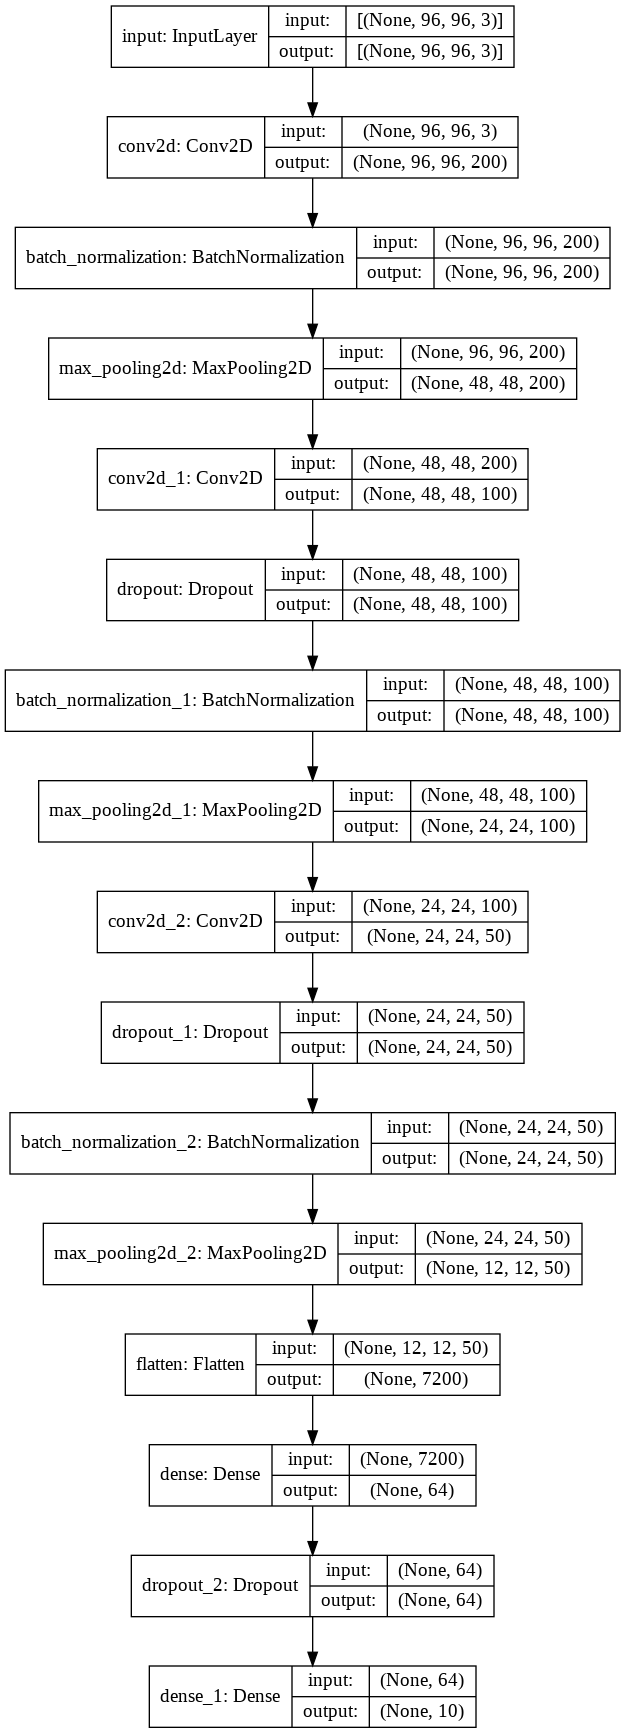

In [ ]:
plot_model(model, 'stl10-Supervised.png', show_shapes=True)

###Training the model

In [ ]:
opt = Adam(learning_rate=0.00004)
earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
model.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer=opt)
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True,monitor='val_loss', mode='min')

In [ ]:
model.summary()

Model: "stl10-Supervised"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 200)       5600      
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 200)       800       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 100)       180100    
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 100)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 100)  

In [ ]:
img_iter = datagen.flow(x_train, y_train, batch_size=64)
#pass images through generator

In [ ]:
history=model.fit(img_iter, epochs=120, verbose=1, validation_data=(x_test,y_test),batch_size=64, callbacks=[earlyStopping, mcp_save])

Epoch 1/120
79/79 [==============================] - 48s 203ms/step - loss: 2.6011 - accuracy: 0.1666 - val_loss: 2.1793 - val_accuracy: 0.2189
Epoch 2/120
79/79 [==============================] - 16s 201ms/step - loss: 2.0712 - accuracy: 0.2364 - val_loss: 1.9528 - val_accuracy: 0.3090
Epoch 3/120
79/79 [==============================] - 18s 226ms/step - loss: 1.9550 - accuracy: 0.2736 - val_loss: 1.8001 - val_accuracy: 0.3585
Epoch 4/120
79/79 [==============================] - 16s 198ms/step - loss: 1.9119 - accuracy: 0.3026 - val_loss: 1.7294 - val_accuracy: 0.3814
Epoch 5/120
79/79 [==============================] - 15s 193ms/step - loss: 1.8344 - accuracy: 0.3272 - val_loss: 1.6617 - val_accuracy: 0.4059
Epoch 6/120
79/79 [==============================] - 17s 219ms/step - loss: 1.7773 - accuracy: 0.3454 - val_loss: 1.6135 - val_accuracy: 0.4216
Epoch 7/120
79/79 [==============================] - 18s 226ms/step - loss: 1.7344 - accuracy: 0.3700 - val_loss: 1.5847 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


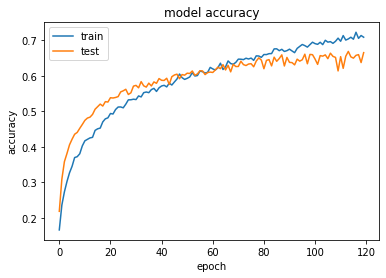

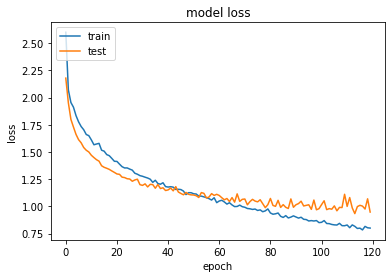

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Pseudo Labelling + Semi Supervised Training

### Making predictions and eliminating all predicitions below the probability of 0.93 

In [ ]:
model.load_weights(filepath = 'mdl_wts.hdf5')

In [ ]:
prob = model.predict(x_unlab)
pred = np.argmax(prob, axis=1)

In [ ]:
print(pred.shape)

(100000,)


In [ ]:
for i, val in enumerate(prob):
    if (max(val)) < 0.93:
        pred[i]=-1
      

### Grouping unlabelled images according to their pseudo labels and storing their indexes together

In [ ]:
idx_pred_0 = (np.where(pred==0))
idx_pred_1 = (np.where(pred==1))
idx_pred_2 = (np.where(pred==2))
idx_pred_3 = (np.where(pred==3))
idx_pred_4 = (np.where(pred==4))
idx_pred_5 = (np.where(pred==5))
idx_pred_6 = (np.where(pred==6))
idx_pred_7 = (np.where(pred==7))
idx_pred_8 = (np.where(pred==8))
idx_pred_9 = (np.where(pred==9))

In [ ]:
new_y_train = y_train.idxmax(axis=1)

In [ ]:
new_y_train.shape

(5000,)

In [ ]:
y_train_pred = new_y_train

In [ ]:
y_train_pred

0       1
1       0
2       8
3       3
4       9
       ..
4995    9
4996    8
4997    7
4998    7
4999    7
Length: 5000, dtype: int64

In [ ]:
min(y_train_pred)

0

In [ ]:
max(y_train_pred)

9

In [ ]:
y_train_pred.shape

(5000,)

###Concatenating the unlablled images along with pseudo labels and the initial training dataset. Pseudo labelled data is taken twice so that in each epoch model trains on the new data twice

In [ ]:
xt1 = np.concatenate((x_unlab[idx_pred_0[0],...],x_unlab[idx_pred_1[0],...],x_unlab[idx_pred_2[0],...],x_unlab[idx_pred_3[0],...],x_unlab[idx_pred_4[0],...],x_unlab[idx_pred_5[0],...],x_unlab[idx_pred_6[0],...],x_unlab[idx_pred_7[0],...],x_unlab[idx_pred_8[0],...],x_unlab[idx_pred_9[0],...]))
yt1 = np.concatenate((np.zeros(idx_pred_0[0].shape[0]),np.ones(idx_pred_1[0].shape[0]),np.ones(idx_pred_2[0].shape[0])*2,np.ones(idx_pred_3[0].shape[0])*3,np.ones(idx_pred_4[0].shape[0])*4,np.ones(idx_pred_5[0].shape[0])*5,np.ones(idx_pred_6[0].shape[0])*6,np.ones(idx_pred_7[0].shape[0])*7,np.ones(idx_pred_8[0].shape[0])*8,np.ones(idx_pred_9[0].shape[0])*9))

In [ ]:
xt2=np.concatenate((xt1,xt1))
yt2=np.concatenate((yt1,yt1))

In [ ]:
Xtrain=np.concatenate((xt2,x_train))
Ytrain=np.concatenate((yt2,y_train_pred))

###Checking/Reshaping data

In [ ]:
Xtrain.shape

(32850, 96, 96, 3)

In [ ]:
Ytrain.shape

(32850,)

In [ ]:
Ytrain_shaped = pd.get_dummies(Ytrain)
#one hot encoding

In [ ]:
Ytrain_shaped.shape

(32850, 10)

### Training model on newly created dataset

In [ ]:
img_iter2 = datagen.flow(Xtrain, Ytrain_shaped , batch_size=32)

In [ ]:
opt = SGD(learning_rate=0.000025)
earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
mcp_save = ModelCheckpoint('mdl_wtsPL.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer=opt)

In [ ]:
history2 = model.fit(img_iter2, batch_size=32, epochs=100, verbose=1, callbacks=[mcp_save,earlyStopping], validation_data=(x_test, y_test))

Epoch 1/100
1027/1027 [==============================] - 89s 86ms/step - loss: 0.4236 - accuracy: 0.8648 - val_loss: 1.0483 - val_accuracy: 0.6446
Epoch 2/100
1027/1027 [==============================] - 90s 87ms/step - loss: 0.3588 - accuracy: 0.8840 - val_loss: 1.0237 - val_accuracy: 0.6507
Epoch 3/100
1027/1027 [==============================] - 89s 86ms/step - loss: 0.3391 - accuracy: 0.8891 - val_loss: 1.0508 - val_accuracy: 0.6459
Epoch 4/100
1027/1027 [==============================] - 89s 87ms/step - loss: 0.3286 - accuracy: 0.8930 - val_loss: 1.0301 - val_accuracy: 0.6509
Epoch 5/100
1027/1027 [==============================] - 90s 88ms/step - loss: 0.3211 - accuracy: 0.8966 - val_loss: 1.0733 - val_accuracy: 0.6371
Epoch 6/100
1027/1027 [==============================] - 89s 86ms/step - loss: 0.3156 - accuracy: 0.8965 - val_loss: 1.0487 - val_accuracy: 0.6447
Epoch 7/100
1027/1027 [==============================] - 87s 85ms/step - loss: 0.3100 - accuracy: 0.8981 - val_loss: 1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


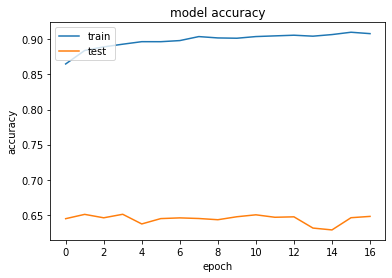

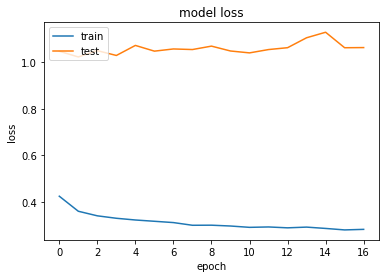

In [ ]:
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights(filepath = 'mdl_wtsPL.hdf5')
scoretr = model.evaluate(x_train, y_train, verbose=0)
print('Train PL CV score:', scoretr[0])
print('Train PL CV accuracy:', scoretr[1])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train PL CV score: 0.6724172234535217
Train PL CV accuracy: 0.7545999884605408
Test score: 1.0236568450927734
Test accuracy: 0.6507499814033508
